# Differential Gene Expression in Acute Myocardial Infraction - HW4
<b>Itay Radotzki</b>

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

## Describing the data

In [2]:
classes = np.delete(np.array((pd.read_csv('./data.csv', skiprows=58, nrows=1, squeeze=True)).values[0]), 0)
data = pd.read_csv('./data.csv', header=60)

### How many genes profiled?

In [3]:
print (data.shape[0] - 1)

54674


### How many samples (patients) in total?

In [4]:
print (data.shape[1] - 1)

99


### How many samples in each class?

In [5]:
class_names = np.unique(classes)

for cname in class_names:
    print (cname, ':', len(np.where(classes == cname)[0]))


H : 50
M : 49


### If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [6]:
data = data.dropna(axis=0, how='any')
print (data.shape[0] - 1)

54627


## WRS for differential expression (DE)

### Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

In [7]:
count_m = len(np.where(classes == 'M')[0])
expected_sum_of_rank = count_m * (len(classes) + 1) / 2
print (expected_sum_of_rank)

2450.0


### Denote this sum of ranks by RS(g). What is the minimal value, m, that RS(g) can take?

In [8]:
a1 = 1
an = count_m
n = count_m

print (int(n * (a1 + an) / 2))

1225


### Under the null model, what is the probability of RS(g) = m? (provide a formula for this and explain it)

In [9]:
# in order to RS(g) to be equal m, all values of genes that labled M need to be lower then the genes labled H, thus:
# all possible permutaions divided by (all permutations of m multiply by all permutations of h):
# 99 choose 49
# for example: [M,M,M,M,H,H,H,H,H]
print (math.factorial(99) / (math.factorial(49) * math.factorial(50)))

5.04456722727821e+28


### Under the null model, what is the probability of RS(g) = m+1? (provide a formula for this and explain it)

In [10]:
# move the last M by one:
# [M,M,M,H,M,H,H,H,H]
# same probability
# 99 choose 49
print (math.factorial(99) / (math.factorial(49) * math.factorial(50)))

5.04456722727821e+28


### Under the null model, what is the probability of RS(g) = m+2? (provide a formula for this and explain it)

In [11]:
# we have two options:
# [M,M,M,H,H,M,H,H,H]
# [M,M,H,M,M,H,H,H,H]
print (math.factorial(99) / (2 * math.factorial(49) * math.factorial(50)))

2.522283613639105e+28


### Draw a histogram of the values of RS(g) when g ranges over all genes in the data (after the clean-up)

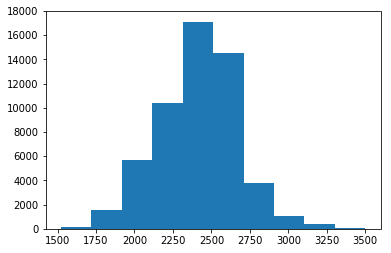

In [12]:
h_idx = np.where(classes == 'H')[0] + 1
m_idx = np.where(classes == 'M')[0] + 1

def sum_of_ranks(x, y):
    values = []

    for i in x:
        values.append((False, i))

    for i in y:
        values.append((True, i))

    dtype = [('class', bool), ('value', float)]
    soretd_arr = np.sort(np.array(values, dtype=dtype), order='value')

    sum_ranks = 0
    for idx in range(0, len(soretd_arr)):
        if soretd_arr[idx][0]:
            sum_ranks += idx

    return sum_ranks


sums = []
for i in range(0, data.shape[0]):
    h_g = np.array(data.iloc[i , h_idx])
    m_g = np.array(data.iloc[i , m_idx])
    sums.append(sum_of_ranks(h_g, m_g))

plt.hist(sums)
plt.show()

## Differential Expression
Determine the statistical significance of differential expression (DE) observed for each gene in H vs M.
Evaluate the DE in both one-sided directions. That is, report genes overexpressed in M vs H and separately genes underexpressed in M vs H.
Use a Student t-test and a WRS test for this analysis.

In [13]:
h_idx = np.where(classes == 'H')[0] + 1
m_idx = np.where(classes == 'M')[0] + 1
h_genes = data.iloc[:, h_idx]
m_genes = data.iloc[:, m_idx]

statistical_significance = 0.05

overexpressed_in_M_wlicoxon = []
overexpressed_in_M_ttest = []
underexpressed_in_M_wilcoxon = []
underexpressed_in_M_ttest = []

for i in range(0, data.shape[0]):
    h_gene = h_genes.iloc[i, :]
    m_gene = m_genes.iloc[i, :]
    
    pval_ttest = stats.ttest_ind(h_gene, m_gene).pvalue
    pval_wilcoxon = stats.ranksums(h_gene, m_gene).pvalue
    
    if (pval_wilcoxon <= statistical_significance):
        if (m_gene.median() > h_gene.median()):
            overexpressed_in_M_wlicoxon.append({'idx': i, 'pval': pval_wilcoxon, 'name': data.iloc[i, 0]})
        else:
            underexpressed_in_M_wilcoxon.append({'idx': i, 'pval': pval_wilcoxon, 'name': data.iloc[i, 0]})
    
    if (pval_ttest <= statistical_significance):
        if (m_gene.median() > h_gene.median()):
            overexpressed_in_M_ttest.append({'idx': i, 'pval': pval_ttest, 'name': data.iloc[i, 0]})
        else:
            underexpressed_in_M_ttest.append({'idx': i, 'pval': pval_ttest, 'name': data.iloc[i, 0]})

print ('overexpressed_in_M_wlicoxon:', len(overexpressed_in_M_wlicoxon))
print ('overexpressed_in_M_ttest:', len(overexpressed_in_M_ttest))
print ('underexpressed_in_M_wilcoxon:', len(underexpressed_in_M_wilcoxon))
print ('underexpressed_in_M_ttest:', len(underexpressed_in_M_ttest))

overexpressed_in_M_wlicoxon: 6424
overexpressed_in_M_ttest: 5043
underexpressed_in_M_wilcoxon: 7537
underexpressed_in_M_ttest: 5570


## Correlations

### Select 60 genes from each one of the DE lists you computed in 3.c, using WRS. Generate a set of 120 genes, D, which is the union of the above two sets. Compute Spearman rho correlations in all pairs within D.

In [14]:
overexpressed_in_M_wlicoxon_idx = []
for i in overexpressed_in_M_wlicoxon[0:60]:
    overexpressed_in_M_wlicoxon_idx.append(i['idx'])
    
underexpressed_in_M_wilcoxon_idx = []
for i in underexpressed_in_M_wilcoxon[0:60]:
    underexpressed_in_M_wilcoxon_idx.append(i['idx'])
    
genes_indices = np.append(overexpressed_in_M_wlicoxon_idx, underexpressed_in_M_wilcoxon_idx)
D = data.iloc[genes_indices, np.append(h_idx, m_idx)]

def calc_spearman(D):
    corr = []

    for i in range(0, 120):
        for j in range(i+1, 120):
            a = np.array(D.iloc[i, :])
            b = np.array(D.iloc[j, :])
            rho, pval = stats.spearmanr(a, b)
            corr.append({'i': i, 'j': j, 'rho': rho, 'pval': pval})
    
    return corr

corr = calc_spearman(D)

### What can you report about co-expression of genes in D (co-expression is the correlation of the expression levels of genes)? Do we observe any significant co-expression? If so how many pairs, etc.

In [15]:
def find_significant_co_expression(corr):
    significant_co_expression = []

    for i in range(0, len(corr)):
        if (corr[i]['pval'] <= statistical_significance and abs(corr[i]['rho']) >= 0.75):
            significant_co_expression.append(corr[i])
    return significant_co_expression

significant_co_expression = find_significant_co_expression(corr)
print (len(significant_co_expression))

12


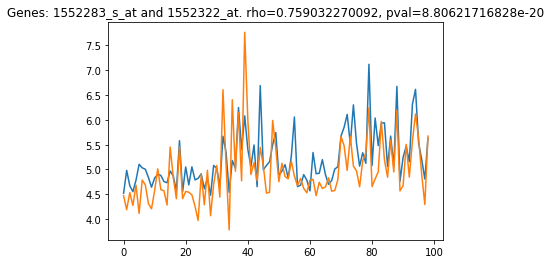

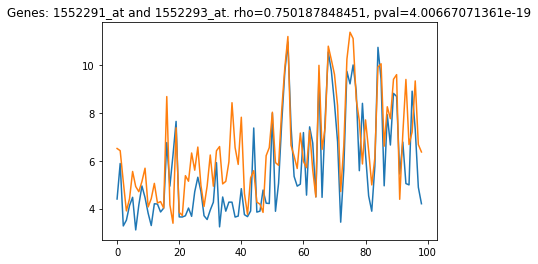

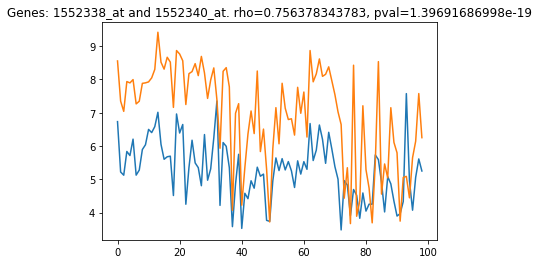

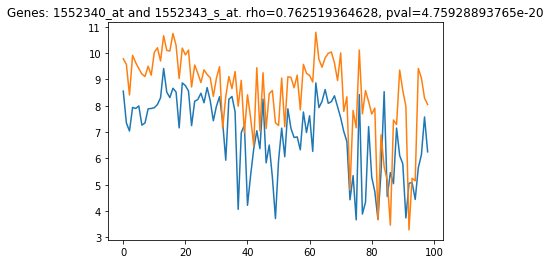

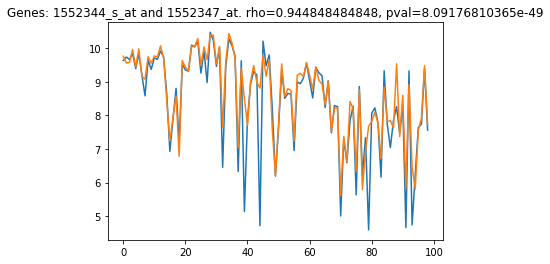

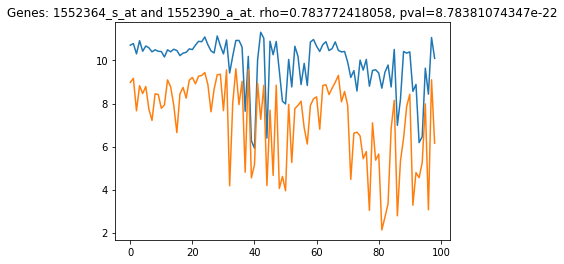

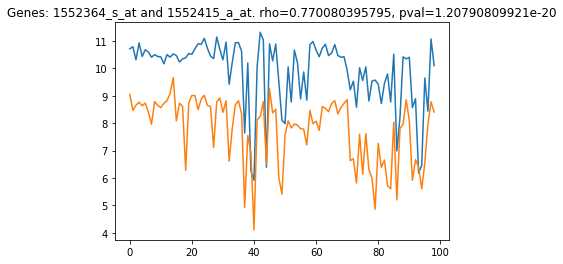

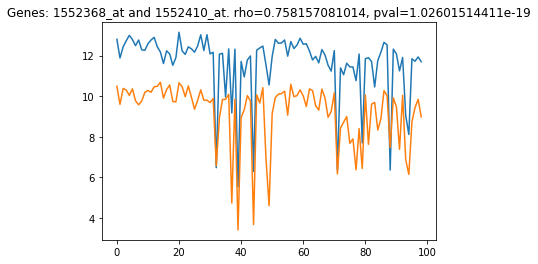

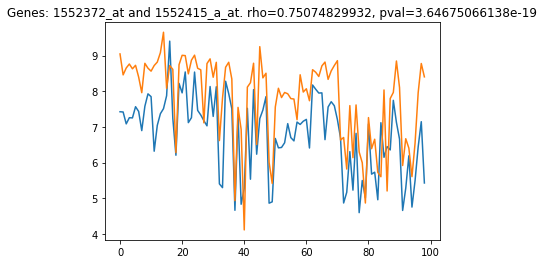

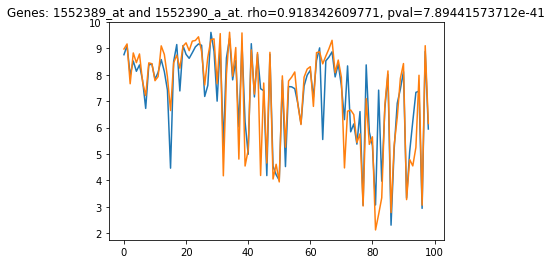

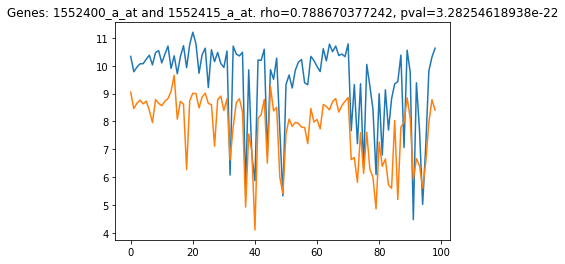

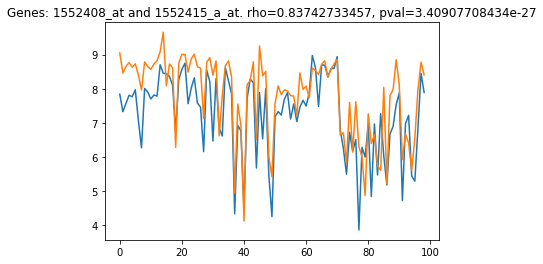

In [16]:
def print_significant_co_expression(significant_co_expression):
    for i in range(0, len(significant_co_expression)):
        item = significant_co_expression[i]
        a = np.array(D.iloc[item['i'], :])
        b = np.array(D.iloc[item['j'], :])
        plt.plot(a)
        plt.plot(b)
        plt.title('Genes: %s and %s. rho=%s, pval=%s' % (data.iloc[item['i'],0], data.iloc[item['j'],0], item['rho'], item['pval']))
        plt.show()

print_significant_co_expression(significant_co_expression)

As we can see, there are 12 significant co-expression pairs with p-value greater than 0.05 and |rho| greater than 0.75.

### What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D?

<b>Advantages: </b>
1. We would not miss significant data

<b>Disadvantages:</b>
1. We could mistakenly state that genes are highly correlated (like the "number of people who drowned into a pool Vs Films Nicolas Cage appeared in" case)
1. It would take a lot of time
1. It would cost a lot of CPU time


### Perform the above steps but restrict attention only to samples labeled H. What do you see now? Can you explain this?

8


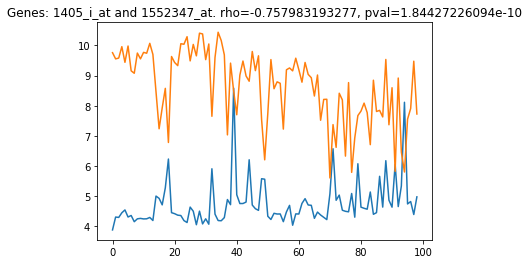

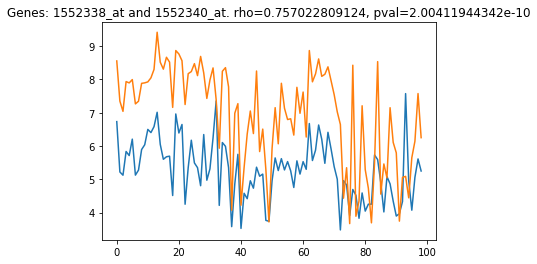

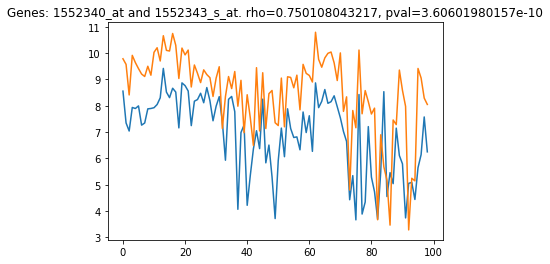

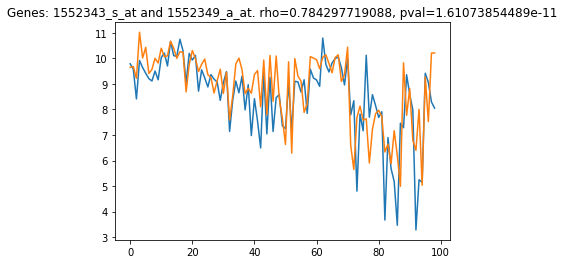

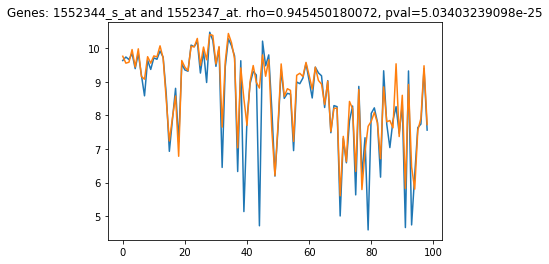

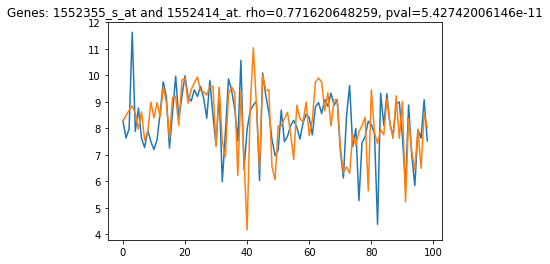

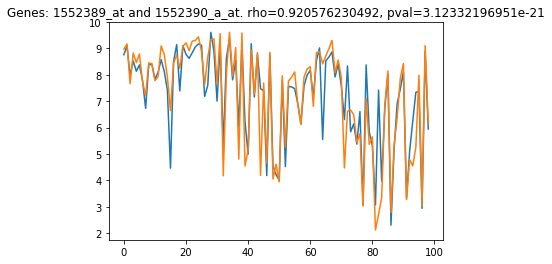

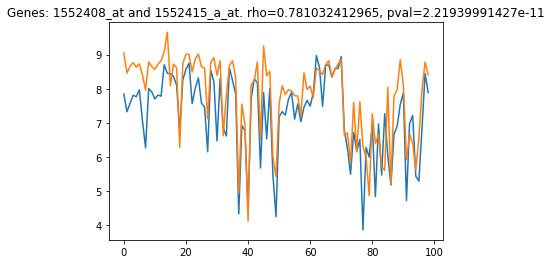

In [17]:
D_h = data.iloc[genes_indices, h_idx]
corr = calc_spearman(D_h)
significant_co_expression = find_significant_co_expression(corr)
print (len(significant_co_expression))
print_significant_co_expression(significant_co_expression)

16


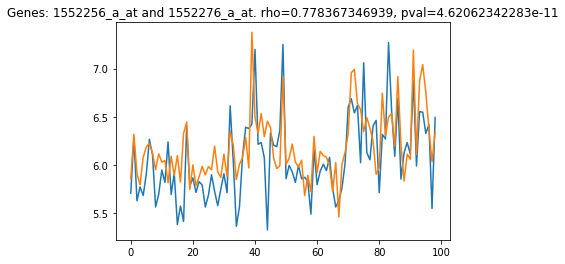

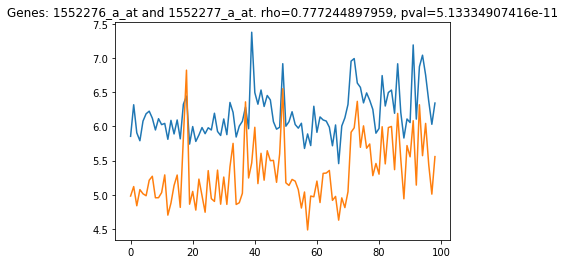

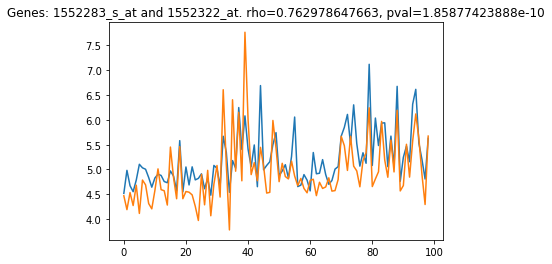

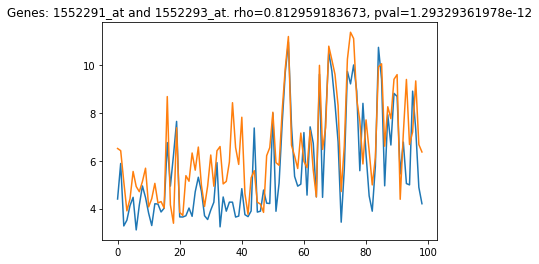

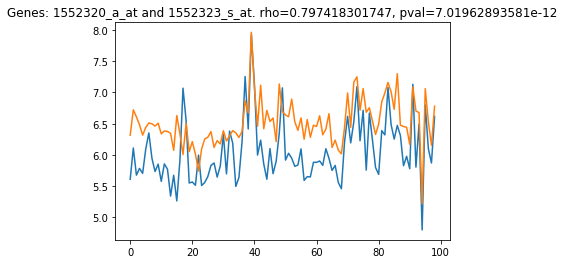

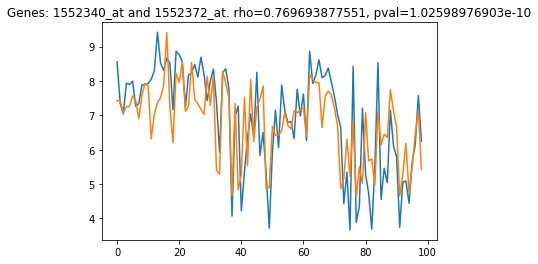

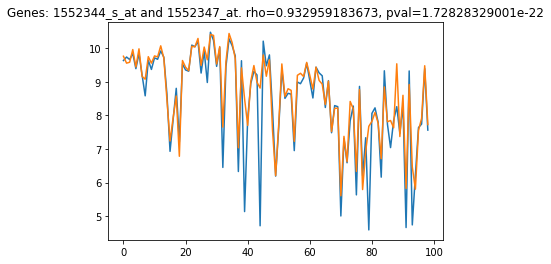

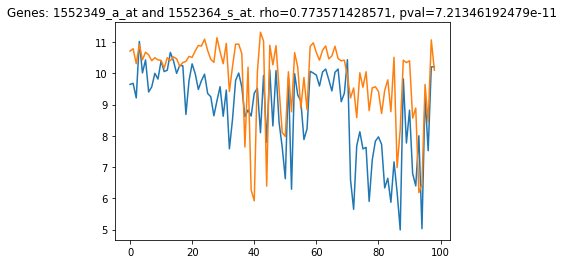

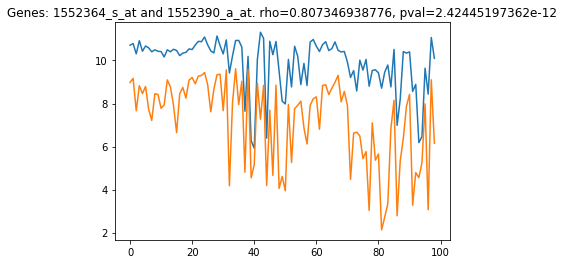

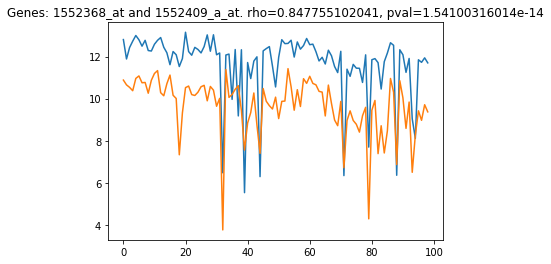

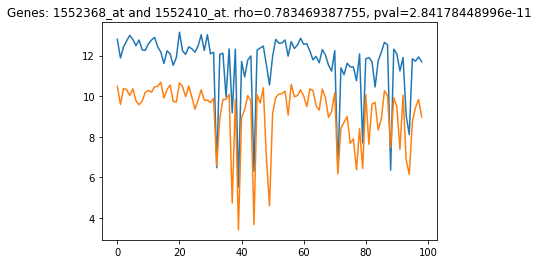

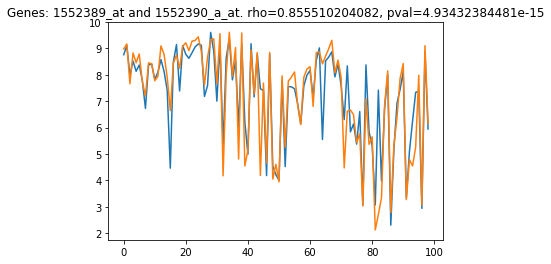

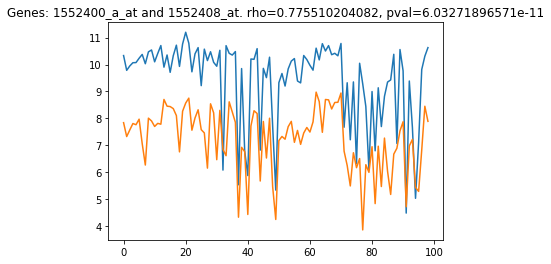

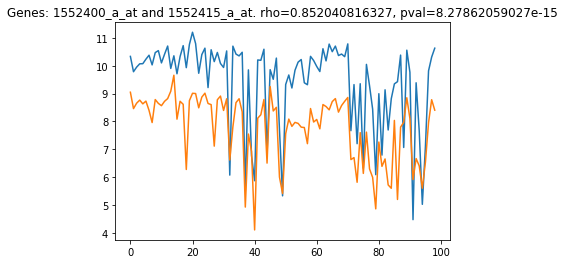

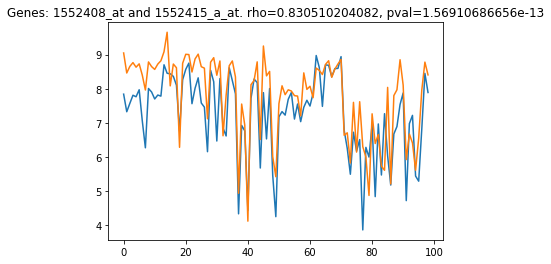

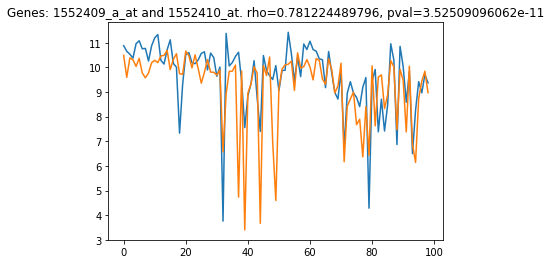

In [18]:
D_m = data.iloc[genes_indices, m_idx]
corr = calc_spearman(D_m)
significant_co_expression = find_significant_co_expression(corr)
print (len(significant_co_expression))
print_significant_co_expression(significant_co_expression)

Now we got 8 significant co-expression pairs with p-value greater than 0.05 and |rho| greater than 0.75.

I did the same for samples labeld M and got 16 pairs. I assume that the reason is that the genes of people with AMI (labled M) are trying to be more identical to each other.

## Plots and Conclusions

Construct the DE overabundance plots (blue and green lines as shown in class) for the DE comparisons you performed (Section 3.c).
State for each comparison, the number of genes, k, at which we observe:
1. FDR = 0.1 
2. FDR = 0.05 
3. FDR=0.001

If these events are not observed at any k, then make that statement.

k=6424


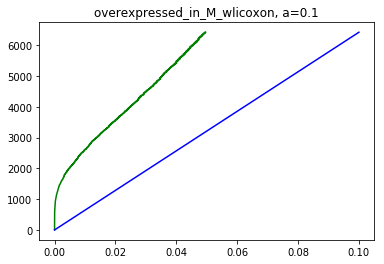

k=5043


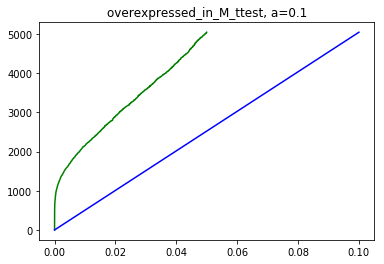

k=7537


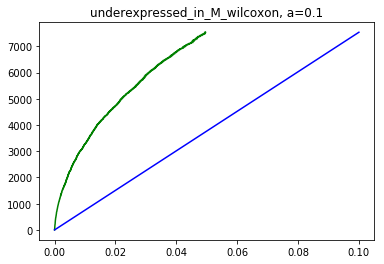

k=5570


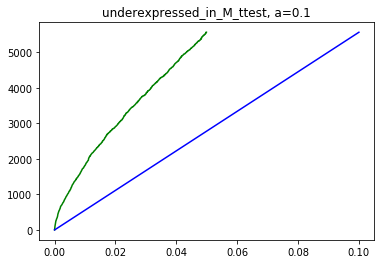

k=6424


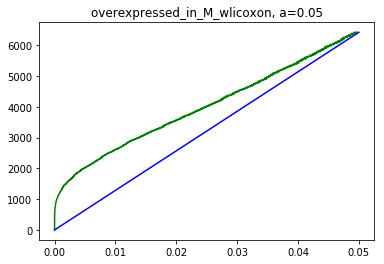

k=5043


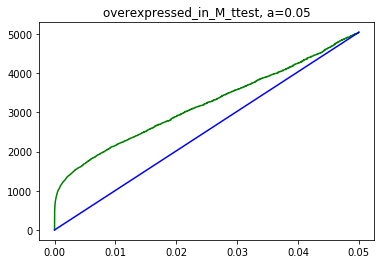

k=7537


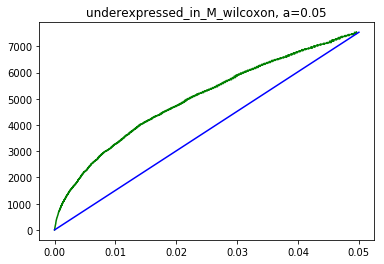

k=5570


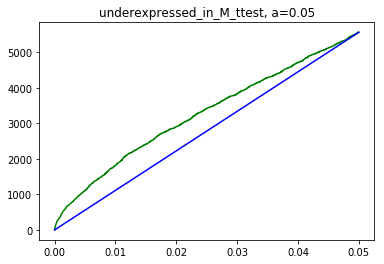

k=1256


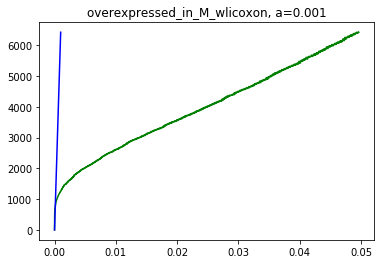

k=1131


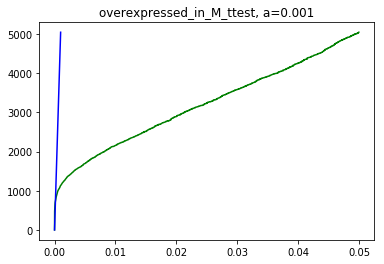

k=851


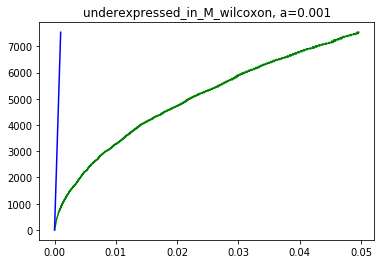

k=387


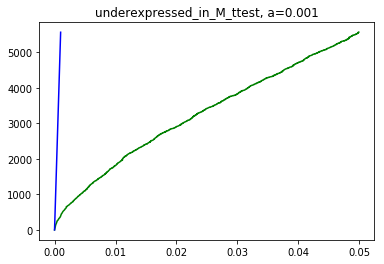

In [19]:
def get_pvals(a):
    pvals = []
    for i in a:
        pvals.append(i['pval'])
    return np.array(pvals)

def overabundance_plot(pvals, a, title):
    pvals_sorted = np.sort(pvals)
    N = len(pvals_sorted)
    fdr = []
    
    for i in range(0, N):
        fdr.append(pvals_sorted[i] * N / (i+1))

    y = range(0, N)
    x_actual = fdr
    
    k = 0

    x_expected = []
    for i in range(0, N):
        x_expected.append(a * (i + 1) / N)

        if (pvals_sorted[i] <= a * (i + 1) / N):
            k += 1
        
    print ('k=%s' % k)
    plt.plot(x_actual, y, color='g')
    plt.plot(x_expected, y, color='b')
    plt.title(title)
    plt.show()

for a in [0.1, 0.05, 0.001]:
    overabundance_plot(get_pvals(overexpressed_in_M_wlicoxon), a, 'overexpressed_in_M_wlicoxon, a=%s' % a)
    overabundance_plot(get_pvals(overexpressed_in_M_ttest), a, 'overexpressed_in_M_ttest, a=%s' % a)
    overabundance_plot(get_pvals(underexpressed_in_M_wilcoxon), a, 'underexpressed_in_M_wilcoxon, a=%s' % a)
    overabundance_plot(get_pvals(underexpressed_in_M_ttest), a, 'underexpressed_in_M_ttest, a=%s' % a)

### What can you say about the difference in results obtained in WRS vs those obtained by Student t-test?
We can see that we get less resluts in t-test, so I can say that t-test is more strict than WRS.

### Select 3 differentially expressed genes, from D (from 3.d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

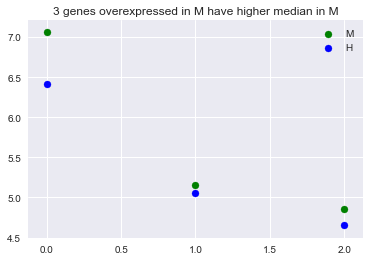

In [24]:
h_medians = []
m_medians = []

for i in range(0, 3):
    de_h = D.iloc[i, 0:D.shape[1] - count_m]
    de_m = D.iloc[i, D.shape[1] - count_m:D.shape[1]]
    h_medians.append(de_h.median())
    m_medians.append(de_m.median())

plt.scatter(range(0,3), m_medians, color='g')
plt.scatter(range(0,3), h_medians, color='b')
plt.title('3 genes overexpressed in M have higher median in M')
plt.legend(['M', 'H'])
plt.show()

### Heatmap: Draw a heatmap representation of the expression values of the genes in D (from 3.d), across the entire cohort.

In [21]:
def sort_by_pval(arr):
    dtype = [('idx', int), ('name', 'S10'), ('pval', float)]
    values = []

    for i in arr:
        values.append((i['idx'], i['name'], i['pval']))

    a = np.array(values, dtype=dtype)
    np.sort(a, order='pval')
    return a

o = sort_by_pval(overexpressed_in_M_wlicoxon)[0:60]
u = sort_by_pval(underexpressed_in_M_wilcoxon)[0:60]

o_idx = []
for i in o:
    o_idx.append(i['idx'])
    
u_idx = []
for i in u:
    u_idx.append(i['idx'])


D2 = data.iloc[np.append(o_idx, u_idx), np.append(m_idx, h_idx)]

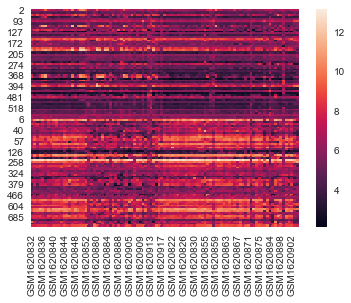

In [22]:
sns.set()
sns.heatmap(D2)
plt.show()